# Make boxplot for BRCA phosphosite

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import statsmodels.stats.multitest
import operator
import cptac.utils as u

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sup18 = pd.read_csv("~/Documents/CPTAC_BC_SupplementaryTable18.csv")
sup18["phospho_site"] =  sup18["RefSeq"] + "_" + sup18["Phosphosite"]
sup18 = sup18[["Gene Name","FDR<5% PIK3CA mutation markers in all tumors and luminal tumors only (upregulated in mutated tumors)", "phospho_site","RefSeq"]]
sup18 = sup18.rename(columns = {"FDR<5% PIK3CA mutation markers in all tumors and luminal tumors only (upregulated in mutated tumors)" : "Significant", "Gene Name" : "Gene_Name"})

#sup18 = sup18.replace(r' ', "_", regex = True)
#sup18

In [3]:
sup18_T = sup18.loc[sup18["Significant"] == True]
sup18_T = sup18_T.set_index("phospho_site")
#sup18_T

# Get phosphoproteomic data from paper

In [4]:
df = pd.read_csv("~/Documents/CPTAC_BC_SupplementaryTable04.csv")
cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,27]
df = df.drop(df.columns[cols],axis=1)
df["phospho_site"] =  df["accession_number"] + "_" + df["variableSites"]
df2 = df.set_index("phospho_site")
#df2

In [5]:
df62 = pd.merge(sup18_T, df2, on = "phospho_site", how = "inner")
df62.columns = df62.columns.str.replace(r'...TCGA', "", regex = True)
df62["Gene_Psite"] =  df62["Gene_Name"] + "_" + df62["variableSites"]
df62 = df62.set_index("Gene_Psite")
#df62.head()

In [6]:
cols = ["Significant","RefSeq","accession_number","geneName","Gene_Name","variableSites"]
df62 = df62.drop(cols, axis = 1) 
#df62.head()

In [7]:
df2 = df62.T
df2.index.names = ['Sample ID']
#df2 = df2.dropna(how = "all", axis = 1)
df2.columns = df2.columns.str.replace(r' ', "", regex = True)
df2.head()

Gene_Psite,FAM184B_S976s,TRIM28_S489s,ARHGEF35_S450s,RPS6KA5_S212s,EIF2AK4_S572s,SRRT_S136s,BCL9_S441s,TP53BP1_S899s,FAM21A_S836s,MAPT_S726sT731t,...,FAM83H_S1024s,WIZ_S289sS294s,DTNBP1_S11s,C1ORF174_S28s,RBM5_S18s,INTS1_S13s,RBM10_S596s,KCTD1_S617sS620s,TAF3_S199s,PRR12_S386s
Sample ID,,,,,,,,,,,,,,,,,,,,,
AO-A12D,-4.916841,-2.624999,-0.017487,0.157644,-0.162349,-0.895306,1.418158,-0.270455,1.491670,-0.596934,...,-0.380722,2.190033,-0.011001,-0.843415,-0.367750,NaN,NaN,-0.780714,-2.134198,-1.223948
C8-A131,-2.966657,0.519513,0.365749,0.965682,-0.836640,1.011056,2.261338,0.980807,2.319315,-3.125463,...,2.619281,1.684090,1.195069,1.429497,1.227838,NaN,NaN,0.385914,-0.776142,0.176694
AO-A12B,-2.954333,-1.597210,-0.562710,0.026429,-1.160616,-0.859032,-1.181656,0.278918,-0.904621,-0.560956,...,0.015909,-1.371022,0.471791,-1.132561,-1.483239,NaN,NaN,0.263137,-2.068872,-1.453432
E2-A10A,-1.798008,1.724957,0.282548,-0.107248,NaN,-0.957562,-0.720724,2.945330,1.488119,-0.200996,...,0.025973,-4.562762,-0.074354,-3.620344,-3.924615,-2.360498,1.057205,-0.342441,0.022684,-1.283214
BH-A18Q,-3.448592,-0.394081,-1.379211,-1.706914,NaN,-1.496537,-1.413600,-0.731897,-1.033303,-4.629940,...,-0.723806,-2.083165,2.480397,-0.938229,-1.336731,-1.150629,-1.237611,-0.764263,-1.348868,-1.138491


# Get mutation data

In [8]:
mutations = pd.read_csv("~/Documents/CPTAC_BC_SupplementaryTable01.csv")
mutations = mutations.set_index("Sample ID")
mutations = mutations[["PIK3CA Mutation"]]
mutations = mutations.rename(columns = {"PIK3CA Mutation" : "PIK3CA_Mutation"})
mutations =  mutations.replace(np.nan, 'Wildtype', regex=True)

In [9]:
# Label hotspots
mutations.loc[mutations.PIK3CA_Mutation.str.contains('E542K')] = "Hotspot"
mutations.loc[mutations.PIK3CA_Mutation.str.contains('E545K')] = "Hotspot"
mutations.loc[mutations.PIK3CA_Mutation.str.contains('H1047R')] = "Hotspot"

In [10]:
merged = pd.merge(df2, mutations, on = "Sample ID", how = "outer")

In [11]:
wt_hotspot = merged.loc[(merged['PIK3CA_Mutation'] == "Wildtype") |
                (merged['PIK3CA_Mutation'] == "Hotspot")]
wt_hotspot.PIK3CA_Mutation.value_counts()

Wildtype    77
Hotspot     17
Name: PIK3CA_Mutation, dtype: int64

# T-tests

In [12]:
test_cols = list(wt_hotspot.columns[:-1])
pval_df = u.wrap_ttest(wt_hotspot, "PIK3CA_Mutation", test_cols , correction_method = 'fdr_bh', 
                     return_all=True, pval_return_corrected=False)

In [13]:
sig_df = pval_df.loc[pval_df['P_Value'] < 0.05] # Keep sig 
ns_df = pval_df.loc[pval_df['P_Value'] > 0.05] # Keep not sig 
print('total number of genes:', len(pval_df))
print('sig genes:', len(sig_df))
print('not sig genes:', len(ns_df))

total number of genes: 62
sig genes: 43
not sig genes: 19


# Plot phosphosite

In [16]:
gene_site = 'MED26_T426t'
plot_df = wt_hotspot[[gene_site,'PIK3CA_Mutation']]

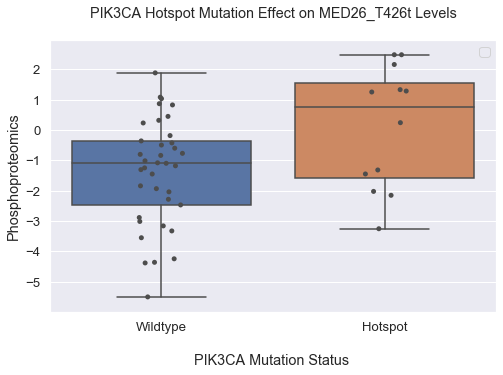

In [17]:
# Plot single phosphosite
plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='PIK3CA_Mutation', y=gene_site, data = plot_df, showfliers = False)    
boxplot.set_title('PIK3CA Hotspot Mutation Effect on '+gene_site +' Levels\n')
boxplot = sns.stripplot(x='PIK3CA_Mutation', y=gene_site, data = plot_df, jitter = True, 
                           color = ".3", dodge = True)
boxplot.set(xlabel = "\nPIK3CA Mutation Status ", ylabel = 'Phosphoproteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Plot multiple phosphosites

In [ ]:
# Select Gene_Psite column names to be plotted - create a long df for boxplot
sig_genes = list(sig_df.Comparison)
ns_genes = list(ns_df.Comparison)

gene_site_list = ns_genes[10:] # change variable to graph other genes

mult_site_df = pd.DataFrame()
for s in gene_site_list:
    site_df = wt_hotspot[[s,'PIK3CA_Mutation']]
    site_df['site'] = s
    site_df = site_df.rename(columns = {s:'phospho'})
    mult_site_df = mult_site_df.append(site_df)
# Check
mult_site_df.tail()

In [ ]:
# Plot multiple phosphosites
plt.rcParams['figure.figsize']=(15,11) #size of plot
sns.set(font_scale = 1.4)

boxplot = sns.boxplot(x='site', y='phospho', data = mult_site_df, hue = 'PIK3CA_Mutation',
                      showfliers = False)    
boxplot.set_title('PIK3CA Hotspot Mutation Effect on Phosphoproteomic Levels\n')
boxplot = sns.stripplot(x='site', y='phospho', data = mult_site_df,hue = 'PIK3CA_Mutation',
                        jitter = True, color = ".3", dodge = True)
boxplot.set(xlabel = "\nPIK3CA Mutation Status ", ylabel = 'Phosphoproteomics')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()